In [133]:
required_packages <- c("plgp", "lhs", "mvtnorm", "laGP", "hetGP")
install.packages(setdiff(required_packages, rownames(installed.packages())))

In [134]:
library(hetGP)

In [135]:
n <- 50
Xn <- matrix(runif(2*n), ncol=2)
Xn <- Xn[order(Xn[,1]),]
ai <- c(8, 27, 38, 45)
mult <- rep(1, n)
mult[ai] <- c(25, 30, 9, 40)
XN <- Xn[rep(1:n, times=mult),]
N <- sum(mult)

In [136]:
KN <- cov_gen(XN, theta=0.2)
Kn <- cov_gen(Xn, theta=0.2)

In [137]:
U <- c(1, rep(0, n - 1))
for(i in 2:n){
  tmp <- rep(0, n)
  tmp[i] <- 1
  U <- rbind(U, matrix(rep(tmp, mult[i]), nrow=mult[i], byrow=TRUE))
}
U <- U[,n:1]

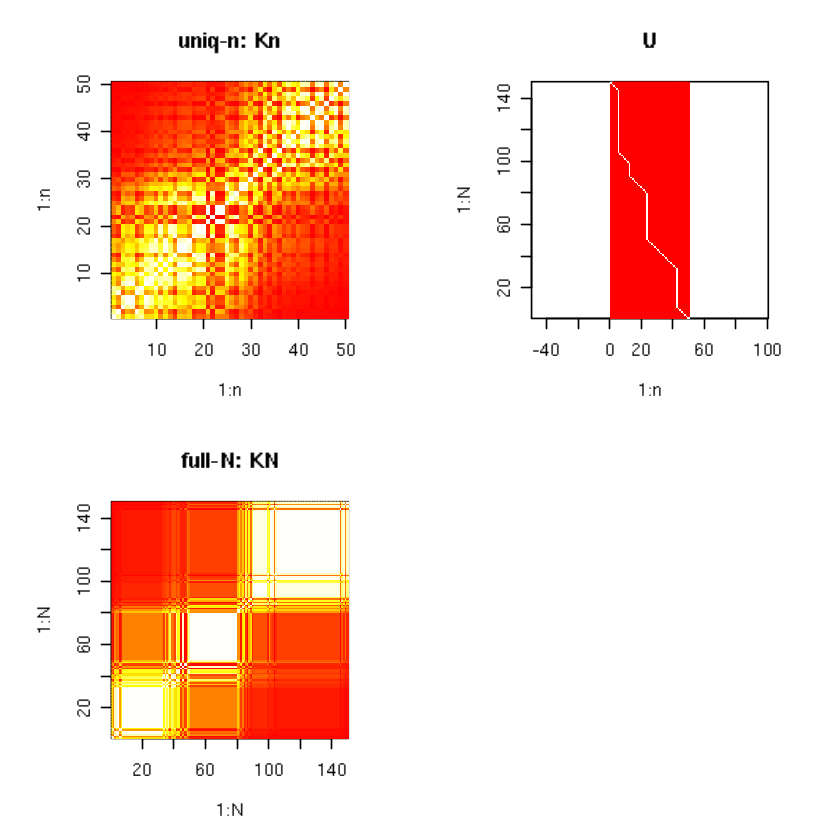

In [138]:
par(pty="s", mfrow=c(2, 2))
cols <- heat.colors(128)
#layout(matrix(c(1, 2, 3), 1, 3, byrow=TRUE), widths=c(2, 1, 2))
image(Kn, x=1:n, y=1:n, main="uniq-n: Kn", xlab="1:n", ylab="1:n", col=cols)
image(t(U), x=1:n, y=1:N, asp=1, main="U", xlab="1:n", ylab="1:N", col=cols)
image(KN, x=1:N, y=1:N, main="full-N: KN", xlab="1:N", ylab="1:N", col=cols)

In [139]:
apply(U, 2, sum)

[1]  1  1  1  1  1 40  1  1  1  1  1  1  9  1  1  1  1  1  1  1  1  1  1 30  1
[26]  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 25  1  1  1  1  1  1  1

In [140]:
library(lhs)
Xbar <- randomLHS(100, 2)
Xbar[,1] <- (Xbar[,1] - 0.5)*6 + 1
Xbar[,2] <- (Xbar[,2] - 0.5)*6 + 1
ytrue <- Xbar[,1]*exp(-Xbar[,1]^2 - Xbar[,2]^2)
a <- sample(1:50, 100, replace=TRUE)
N <- sum(a)
X <- matrix(NA, ncol=2, nrow=N)
y <- rep(NA, N)
nf <- 0
for(i in 1:100) {
  X[(nf+1):(nf+a[i]),] <- matrix(rep(Xbar[i,], a[i]), ncol=2, byrow=TRUE)
  y[(nf+1):(nf+a[i])] <- ytrue[i] + rnorm(a[i], sd=0.01)
  nf <- nf + a[i]
}

In [141]:
Lwr <- rep(sqrt(.Machine$double.eps), 2) 
Upr <- rep(10, 2)
fN <- mleHomGP(list(X0=X, Z0=y, mult=rep(1, N)), y, Lwr, Upr)
un <- mleHomGP(X, y, Lwr, Upr)

In [142]:
c(fN=fN$time, un=un$time)

fN.elapsed un.elapsed 
     8.144      0.043

In [143]:
rbind(fN=fN$theta, un=un$theta)

fN,1.104657,1.922638
un,1.104676,1.922606


## 10.2 Coupled mean and variance GPs

In [144]:
library(MASS)
hom <- mleHomGP(mcycle$times, mcycle$accel)
Xgrid <- matrix(seq(0, 60, length=301), ncol=1)
p <- predict(x=Xgrid, object=hom)
df <- data.frame(table(hom$mult))
colnames(df) <- c("reps", "howmany")
rownames(df) <- NULL
df

reps,howmany
<fct>,<int>
1,66
2,22
3,3
4,2
6,1


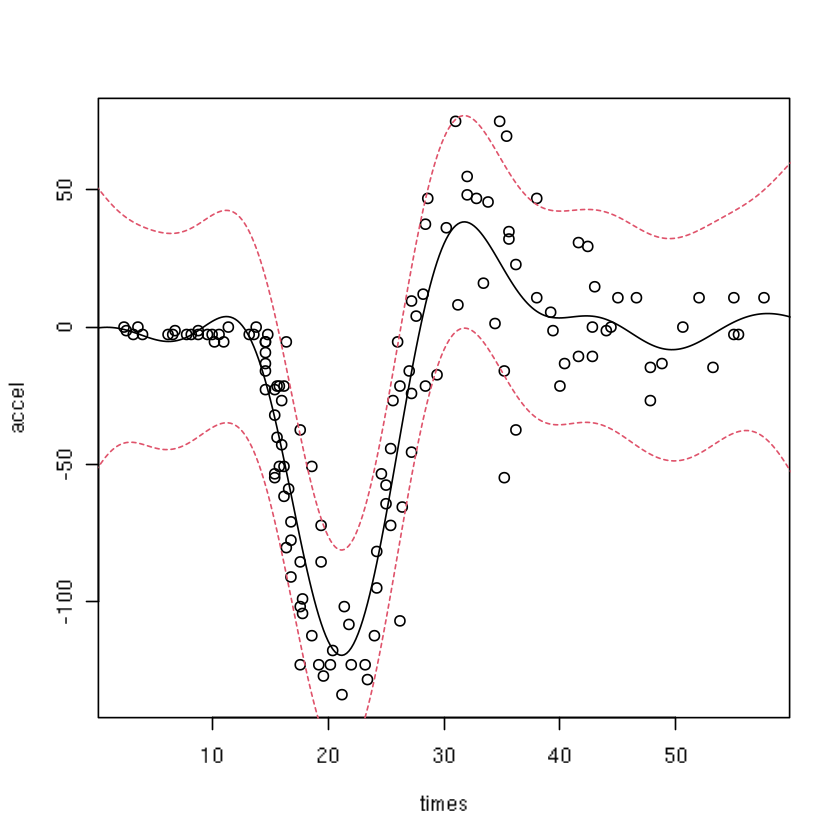

In [145]:
plot(mcycle)
lines(Xgrid, p$mean)
lines(Xgrid, qnorm(0.05, p$mean, sqrt(p$sd2 + p$nugs)), col=2, lty=2)
lines(Xgrid, qnorm(0.95, p$mean, sqrt(p$sd2 + p$nugs)), col=2, lty=2)

### 10.2.2 Illustrations with hetGP

In [146]:
het <- mleHetGP(mcycle$times, mcycle$accel, covtype="Matern5_2", 
  settings=list(initStrategy="smoothed"))
het$time

elapsed 
  0.292

In [147]:
p2 <- predict(het, Xgrid)
ql <- qnorm(0.05, p2$mean, sqrt(p2$sd2 + p2$nugs))
qu <- qnorm(0.95, p2$mean, sqrt(p2$sd2 + p2$nugs))

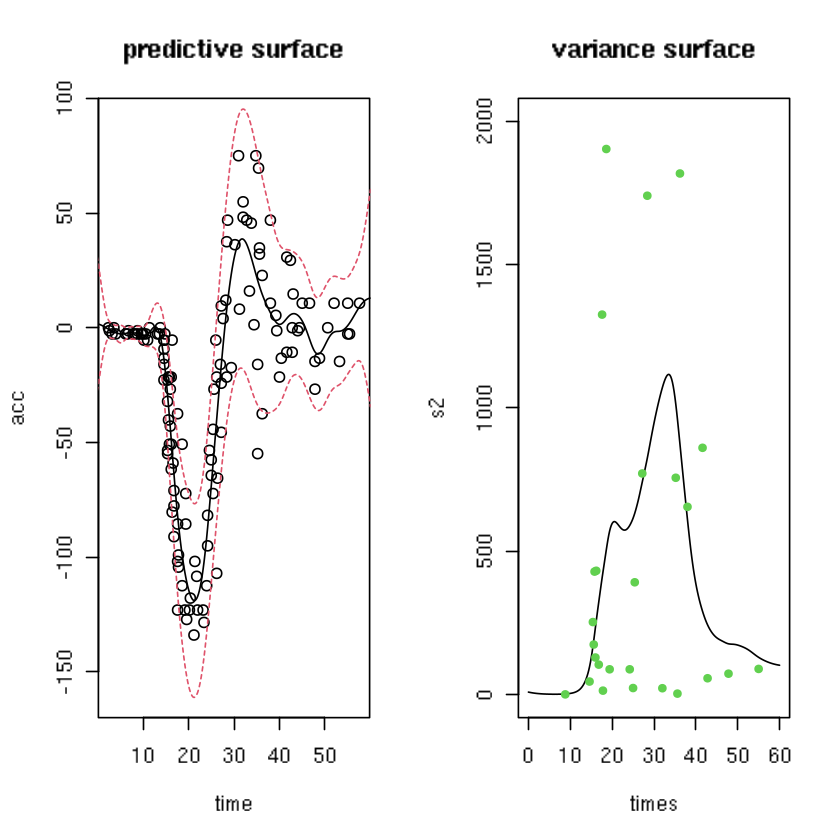

In [148]:
par(mfrow=c(1,2))
plot(mcycle, ylim=c(-160, 90), ylab="acc", xlab="time", 
  main="predictive surface")
lines(Xgrid, p2$mean)
lines(Xgrid, ql, col=2, lty=2)
lines(Xgrid, qu, col=2, lty=2)
plot(Xgrid, p2$nugs, type="l", ylab="s2", xlab="times", 
  main="variance surface", ylim=c(0, 2e3))
points(het$X0, sapply(find_reps(mcycle[,1], mcycle[,2])$Zlist, var), 
  col=3, pch=20)

In [149]:
Xbar <- randomLHS(200, 2)
a <- sample(1:100, nrow(Xbar), replace=TRUE)
X <- matrix(NA, ncol=2, nrow=sum(a))
nf <- 0
for(i in 1:nrow(Xbar)) {
  X[(nf+1):(nf+a[i]),] <- matrix(rep(Xbar[i,], a[i]), ncol=2, byrow=TRUE)
  nf <- nf + a[i]
}
nf

[1] 9605

In [150]:
Y <- apply(X, 1, sirEval)

In [151]:
fit <- mleHetGP(X, Y, settings=list(linkThetas="none"),
  covtype="Matern5_2", maxit=1e4)
fit$time

elapsed 
  1.319

In [152]:
xx <- seq(0, 1, length=100)
XX <- as.matrix(expand.grid(xx, xx))
psir <- predict(fit, XX)
vsir <- psir$sd2 + psir$nugs

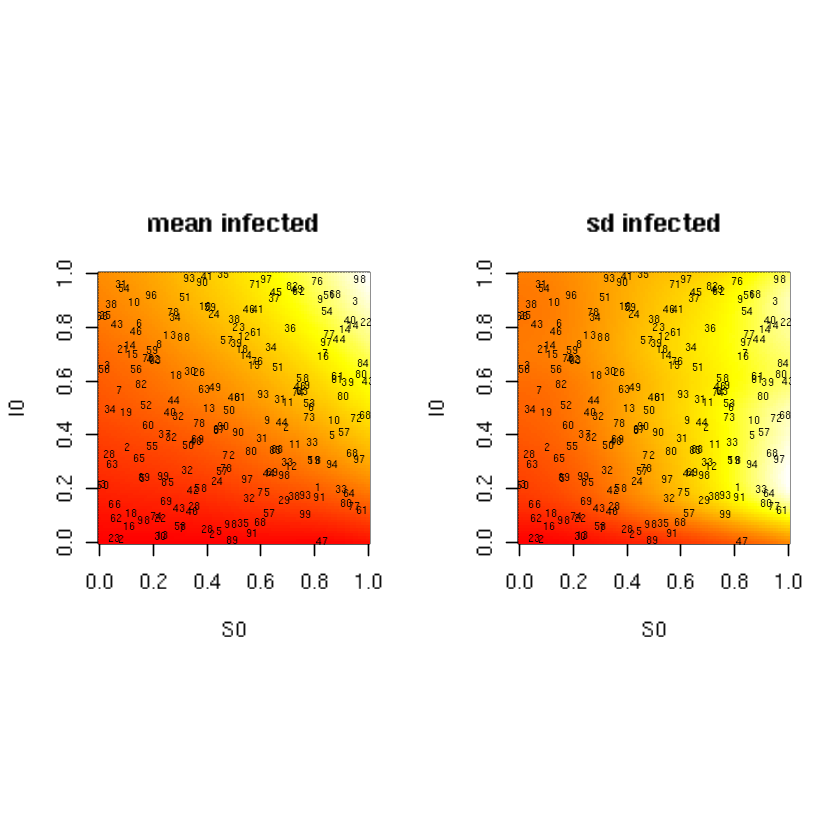

In [153]:
par(mfrow=c(1,2), pty="s")
image(xx, xx, matrix(psir$mean, ncol=100), xlab="S0", ylab="I0", 
  col=cols, main="mean infected")
text(Xbar, labels=a, cex=0.5)
image(xx, xx, matrix(sqrt(vsir), ncol=100), xlab="S0", ylab="I0", 
  col=cols, main="sd infected")
text(Xbar, labels=a, cex=0.5)

In [154]:
data(bfs)
thetas <- matrix(bfs.exp$theta, ncol=1)
bfs <- as.matrix(t(bfs.exp[,-1]))

In [155]:
bfs

bf1,1.230146e-03,0.0008991423,0.029317829,0.0048796041,0.014363308,0.09589525,0.09681164,0.44346542,1.54739925,0.21106858,1.2700482,6.6806029,3.002981,8.429894,43.50464,99.24248,528.1476,3638.740,138126.64,9920073908
bf2,1.034472e-02,0.0193934431,0.030572425,0.0061339372,0.018152832,0.29610444,0.02711918,0.02865752,1.86695686,0.31407810,1.6485245,0.9498262,3.530151,6.653500,16.99512,70.06583,283.5643,8777.067,195112.56,64482423
bf3,3.228363e-03,0.0301940863,0.010819559,0.0102520184,0.024876251,0.09242734,0.24635079,0.17915292,0.13530942,0.28103463,1.6953513,12.4906715,5.299473,4.804362,20.91722,178.10719,433.6010,3622.598,166352.89,30013751
bf4,1.276664e-02,0.0028483552,0.050413542,0.0624240248,0.022074925,0.02717421,0.02591210,0.09877678,0.05264542,2.06857352,5.5659283,11.5189462,2.392091,18.575141,20.63218,86.01049,327.1978,9433.213,101365.09,14520168
bf5,3.169997e-04,0.0069606280,0.004729641,0.0061303231,0.027458748,0.09832915,0.08143677,0.12704006,3.80375430,0.28882201,0.3972488,6.9365714,1.707040,5.751622,12.66194,99.37810,2226.4475,4150.013,112831.63,8967502
bf6,4.743076e-03,0.0001927240,0.004301072,0.0761130966,0.002614044,0.03481161,0.26774794,0.17362640,0.16463717,4.63435617,0.3735562,3.5538431,2.399753,10.129175,21.03479,71.98737,387.6064,3441.147,96561.17,568886060
bf7,2.649111e-03,0.0053186974,0.014536842,0.0005641804,2.491957266,0.10769954,0.23792461,0.14690147,0.48826489,0.72205202,0.3364624,1.5892837,3.623432,7.976297,15.65619,52.90798,347.1547,6124.822,108911.03,12822928
bf8,8.232696e-05,0.0001506891,0.105873696,0.0190618312,2.415582256,0.03038019,0.02269517,0.06626048,0.25054448,0.09503079,0.4749117,2.4719577,1.680382,9.675307,20.95447,71.28979,415.4427,2255.461,109502.13,11312656
bf9,3.356329e-05,0.0001736564,0.075017319,0.0054848981,0.024918141,4.67331597,0.11641179,0.24963394,0.08562280,0.19592566,4.0251631,6.4110511,6.475983,5.036467,96.48693,40.69130,283.4917,3868.693,108188.60,62524439
bf10,7.220537e-03,0.0032831101,0.008074395,0.1879751594,0.159462454,0.06240952,0.20666030,0.18391219,0.26579511,1.02110917,0.8689592,1.9585369,5.455957,7.359946,25.15752,86.98815,559.3772,6465.492,105493.94,12840679


In [156]:
bfs1 <- mleHetTP(X=list(X0=log10(thetas), Z0=colMeans(log(bfs)), 
  mult=rep(nrow(bfs), ncol(bfs))), Z=log(as.numeric(bfs)), lower=1e-4, 
  upper=5, covtype="Matern5_2")

In [157]:
dx <- seq(0, 1, length=100)
dx <- 10^(dx*4 - 3)
p <- predict(bfs1, matrix(log10(dx), ncol=1))

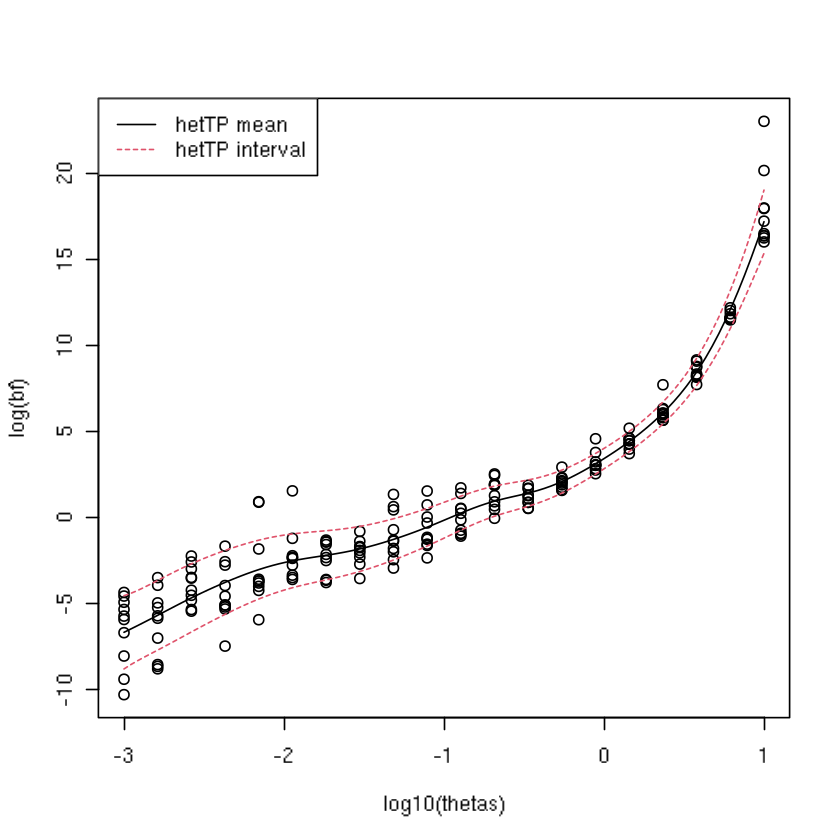

In [158]:
matplot(log10(thetas), t(log(bfs)), col=1, pch=21, ylab="log(bf)")
lines(log10(dx), p$mean)
lines(log10(dx), p$mean + 2*sqrt(p$sd2 + p$nugs), col=2, lty=2)
lines(log10(dx), p$mean - 2*sqrt(p$sd2 + p$nugs), col=2, lty=2)
legend("topleft", c("hetTP mean", "hetTP interval"), col=1:2, lty=1:2)

In [159]:
D <- as.matrix(bfs.gamma[,1:2])
bfs <- as.matrix(t(bfs.gamma[,-(1:2)]))

In [160]:
bfs2 <- mleHetTP(X=list(X0=log10(D), Z0=colMeans(log(bfs)), 
  mult=rep(nrow(bfs), ncol(bfs))), Z=log(as.numeric(bfs)), 
  lower=rep(1e-4, 2), upper=rep(5, 2), covtype="Matern5_2")

In [161]:
dx <- seq(0, 1, length=100)
dx <- 10^(dx*4 - 3)
DD <- as.matrix(expand.grid(dx, dx))
p <- predict(bfs2, log10(DD))

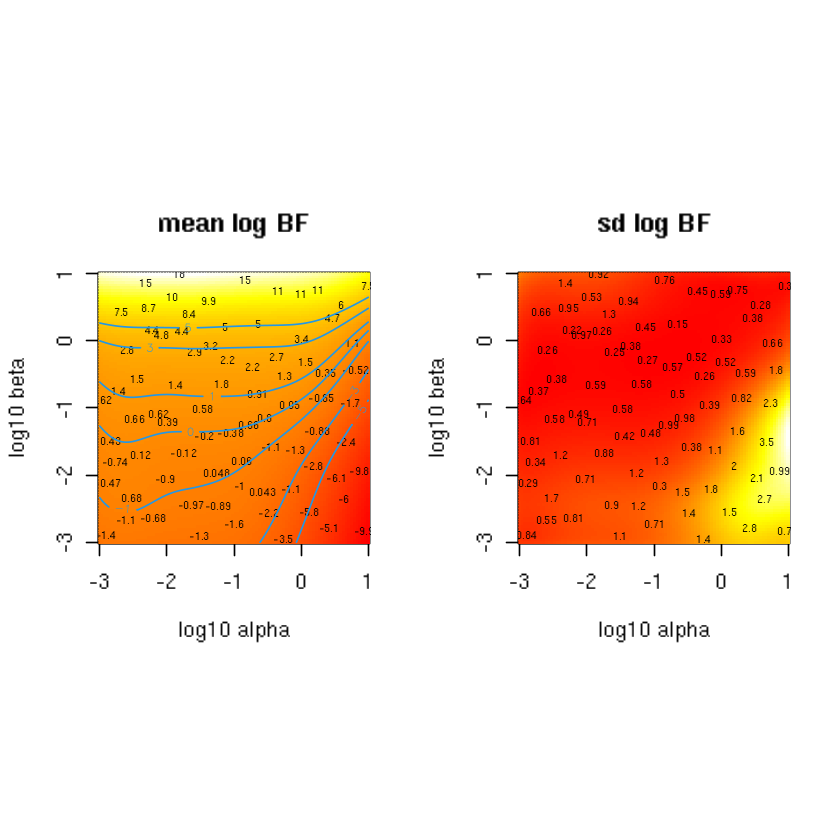

In [162]:
par(mfrow=c(1,2), pty="s")
mbfs <- colMeans(bfs)
image(log10(dx), log10(dx), t(matrix(p$mean, ncol=length(dx))), col=cols, 
  xlab="log10 alpha", ylab="log10 beta",  main="mean log BF")
text(log10(D[,2]), log10(D[,1]), signif(log(mbfs), 2), cex=0.5)
contour(log10(dx), log10(dx), t(matrix(p$mean, ncol=length(dx))),
  levels=c(-5,-3,-1,0,1,3,5), add=TRUE, col=4)
image(log10(dx), log10(dx), t(matrix(sqrt(p$sd2 + p$nugs), 
  ncol=length(dx))), co =cols, xlab="log10 alpha", 
  ylab="log10 beta", main="sd log BF")
text(log10(D[,2]), log10(D[,1]), signif(apply(log(bfs),2,sd), 2), cex=0.5)

In [163]:
data(ato)
c(n=nrow(Xtrain), N=length(unlist(Ztrain)), time=out$time)

n            N time.elapsed 
    1000.000     5594.000     8583.767

In [164]:
phet <- predict(out, Xtest)
phets2 <- phet$sd2 + phet$nugs
mhet <- as.numeric(t(matrix(rep(phet$mean, 10), ncol=10)))
s2het <- as.numeric(t(matrix(rep(phets2, 10), ncol=10)))
sehet <- (unlist(t(Ztest)) - mhet)^2
sc <- - sehet/s2het - log(s2het)
mean(sc)

[1] 3.391718

In [165]:
phet.out <- predict(out, Xtrain.out)
phets2.out <- phet.out$sd2 + phet.out$nugs
s2het.out <- mhet.out <- Ztrain.out
for(i in 1:length(mhet.out)) {
  mhet.out[[i]] <- rep(phet.out$mean[i], length(mhet.out[[i]]))
  s2het.out[[i]] <- rep(phets2.out[i], length(s2het.out[[i]]))
}
mhet.out <- unlist(t(mhet.out))
s2het.out <- unlist(t(s2het.out))
sehet.out <- (unlist(t(Ztrain.out)) - mhet.out)^2
sc.out <- - sehet.out/s2het.out - log(s2het.out)
mean(sc.out)

[1] 5.092274

In [166]:
mean(c(sc, sc.out))

[1] 3.924631

### 10.3.1 Integrated mean-squared prediction error

In [167]:
rn <- c(6, 4, 5, 6.5, 5) 
X0 <- matrix(seq(0.2, 0.8, length.out=length(rn)))
X1 <- matrix(c(X0, 0.3, 0.4, 0.9, 1))
Y1 <- c(rn, 4.7, 4.6, 6.3, 4.5)
r1 <- splinefun(x=X1, y=Y1, method="natural")
X2 <- matrix(c(X0, 0.0, 0.3))
Y2 <- c(rn, 7, 2)
r2 <- splinefun(x=X2, y=Y2, method="natural")

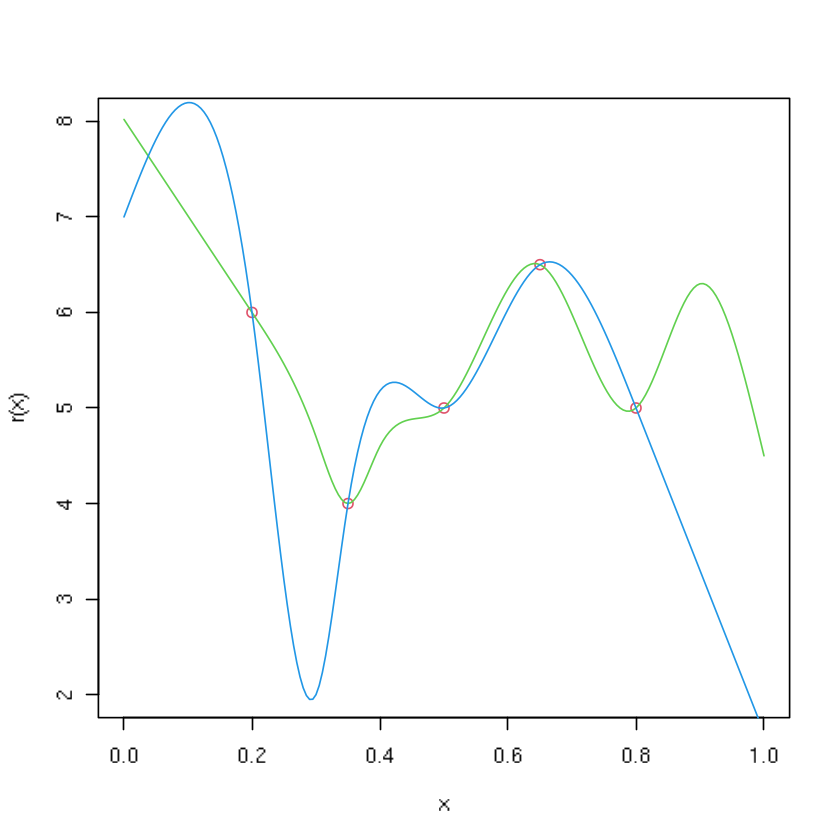

In [168]:
xx <- matrix(seq(0, 1, by=0.005))
plot(X0, rn, xlab="x", ylab="r(x)", xlim=c(0,1), ylim=c(2,8), col=2)
lines(xx, r1(xx), col=3)
lines(xx, r2(xx), col=4)

In [169]:
IMSPE.r <- function(x, X0, theta, r) {
  x <- matrix(x, nrow = 1)
  Wijs <- Wij(mu1=rbind(X0, x), theta=theta, type="Gaussian")
  K <- cov_gen(X1=rbind(X0, x), theta=theta)
  K <- K + diag(apply(rbind(X0, x), 1, r))
  return(1 - sum(solve(K)*Wijs))
}

In [170]:
imspe1 <- apply(xx, 1, IMSPE.r, X0=X0, theta=0.25, r=r1)
imspe2 <- apply(xx, 1, IMSPE.r, X0=X0, theta=0.25, r=r2)
xstar1 <- which.min(imspe1)
xstar2 <- which.min(imspe2)

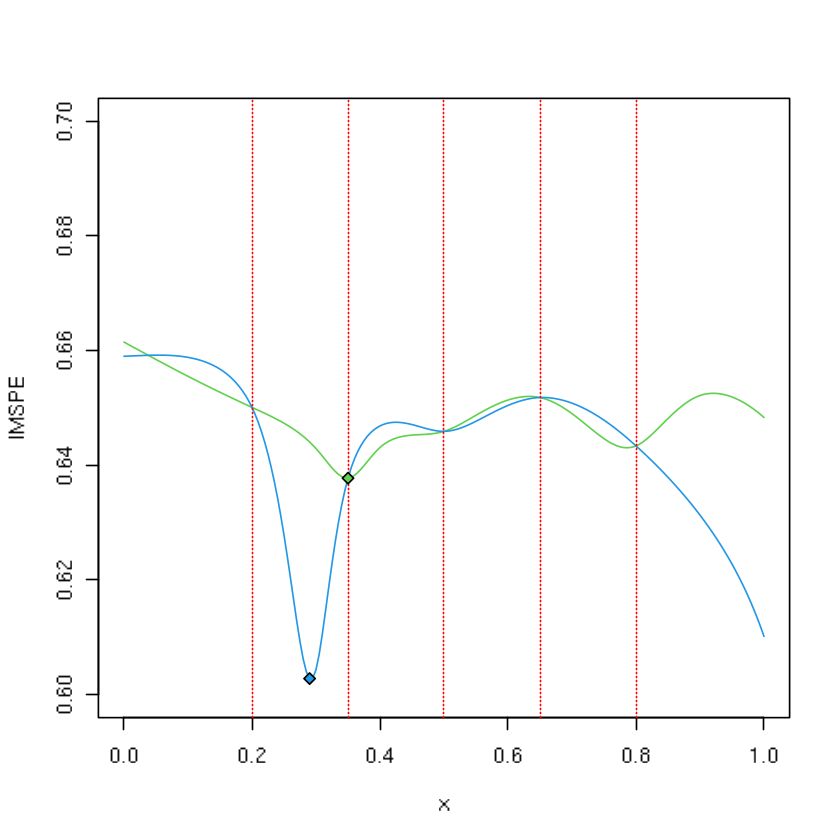

In [171]:
plot(xx, imspe1, type="l", col=3, ylab="IMSPE", xlab="x", ylim=c(0.6, 0.7))
lines(xx, imspe2, col=4)
abline(v=X0, lty=3, col='red')
points(xx[xstar1], imspe1[xstar1], pch=23, bg=3)
points(xx[xstar2], imspe2[xstar2], pch=23, bg=4)

### 10.3.2 Lookahead over replication

In [172]:
fr <- function(x) { (1.1 + sin(2*pi*x)) }
fY <- function(x) { f1d(x) + rnorm(length(x), sd=fr(x)) }

In [173]:
X <- seq(0, 1, length=10)
Y <- fY(X)
mod <- mleHetGP(X=X, Z=Y, lower=0.0001, upper=10)

In [174]:
opt <- IMSPE_optim(mod, h=5) 
X <- c(X, opt$par)
X

[1] 0.0000000 0.1111111 0.2222222 0.3333333 0.4444444 0.5555556 0.6666667
 [8] 0.7777778 0.8888889 1.0000000 0.7777778

In [175]:
ynew <- fY(opt$par)
Y <- c(Y, ynew)
mod <- update(mod, Xnew=opt$par, Znew=ynew, ginit=mod$g*1.01)

In [176]:
for(i in 1:489) {
  
  ## find the next point and update 
  opt <- IMSPE_optim(mod, h=5)
  X <- c(X, opt$par)
  ynew <- fY(opt$par)
  Y <- c(Y, ynew)
  mod <- update(mod, Xnew=opt$par, Znew=ynew, ginit=mod$g*1.01)
  
  ## periodically attempt a restart to try to escape local modes
  if(i %% 25 == 0){ 
    mod2 <- mleHetGP(X=list(X0=mod$X0, Z0=mod$Z0, mult=mod$mult), Z=mod$Z, 
      lower=0.0001, upper=1)
    if(mod2$ll > mod$ll) mod <- mod2
  } 
}
nrow(mod$X0)

[1] 70

In [177]:
xgrid <- seq(0, 1, length=1000)
p <- predict(mod, matrix(xgrid, ncol=1)) 
pvar <- p$sd2 + p$nugs

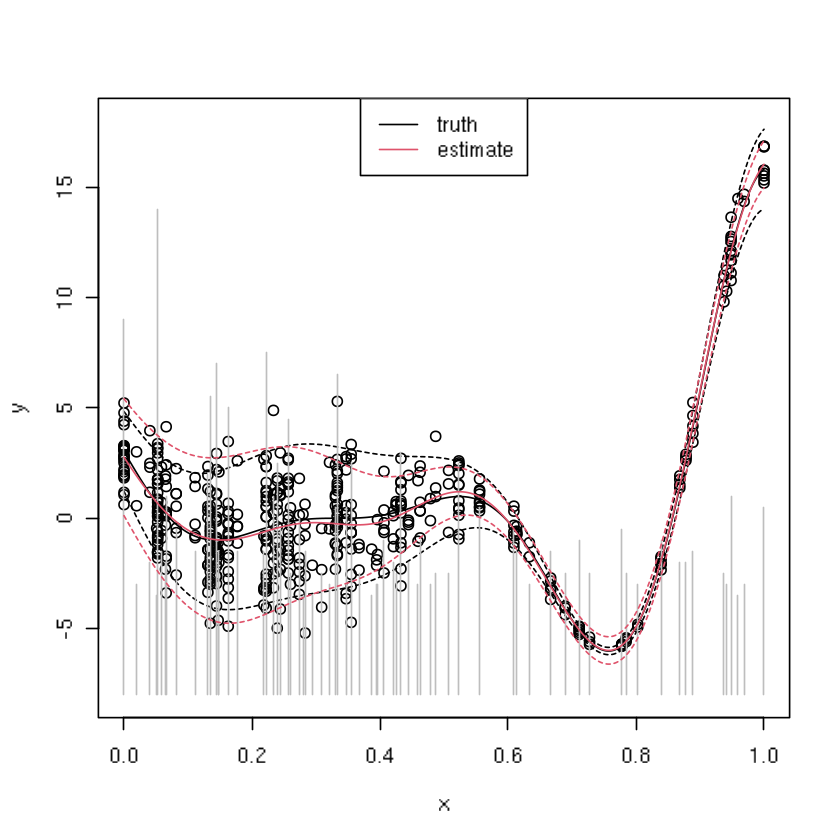

In [178]:
plot(xgrid, f1d(xgrid), type="l", xlab="x", ylab="y", ylim=c(-8,18))
lines(xgrid, qnorm(0.05, f1d(xgrid), fr(xgrid)), col=1, lty=2)
lines(xgrid, qnorm(0.95, f1d(xgrid), fr(xgrid)), col=1, lty=2)
points(X, Y)
segments(mod$X0, rep(0, nrow(mod$X0)) - 8, mod$X0, 
  (mod$mult - 8)*0.5, col="gray")
lines(xgrid, p$mean, col=2)
lines(xgrid, qnorm(0.05, p$mean, sqrt(pvar)), col=2, lty=2)
lines(xgrid, qnorm(0.95, p$mean, sqrt(pvar)), col=2, lty=2)
legend("top", c("truth", "estimate"), col=1:2, lty=1)

In [179]:
X <- X[1:10]
Y <- Y[1:10]
mod.a <- mleHetGP(X=X, Z=Y, lower=0.0001, upper=10)
h <- rep(NA, 500)

In [180]:
for(i in 1:490) {
  
  ## adaptively adjust the lookahead horizon
  h[i] <- horizon(mod.a)
  
  ## find the next point and update 
  opt <- IMSPE_optim(mod.a, h=h[i])
  X <- c(X, opt$par)
  ynew <- fY(opt$par)
  Y <- c(Y, ynew)
  mod.a <- update(mod.a, Xnew=opt$par, Znew=ynew, ginit=mod.a$g*1.01)
  
  ## periodically attempt a restart to try to escape local modes
  if(i %% 25 == 0){ 
    mod2 <- mleHetGP(X=list(X0=mod.a$X0, Z0=mod.a$Z0, mult=mod.a$mult), 
      Z=mod.a$Z, lower=0.0001, upper=1)
    if(mod2$ll > mod.a$ll) mod.a <- mod2
  } 
}

In [181]:
p.a <- predict(mod.a, matrix(xgrid, ncol=1))
pvar.a <- p.a$sd2 + p.a$nugs

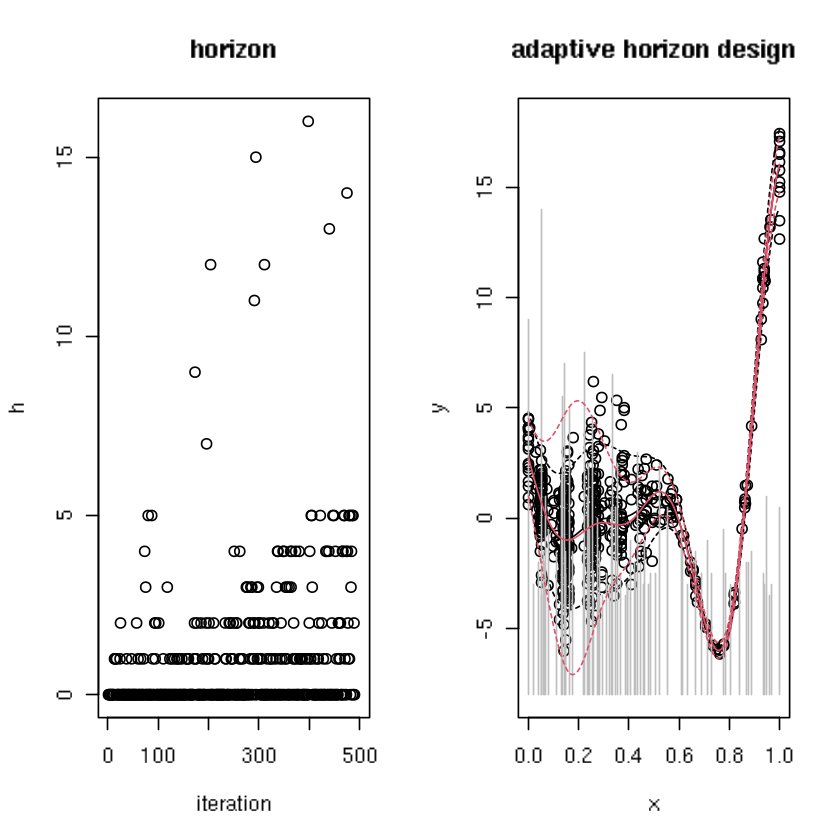

In [182]:
par(mfrow = c(1,2))
plot(h, main="horizon", xlab="iteration")
plot(xgrid, f1d(xgrid), type="l", xlab="x", ylab="y", 
  main="adaptive horizon design", ylim=c(-8,18))
lines(xgrid, qnorm(0.05, f1d(xgrid), fr(xgrid)), col=1, lty=2)
lines(xgrid, qnorm(0.95, f1d(xgrid), fr(xgrid)), col=1, lty=2)
points(X, Y)
segments(mod$X0, rep(0,nrow(mod$X0)) - 8, mod$X0, 
  (mod$mult - 8)*0.5,  col="gray")
lines(xgrid, p$mean, col=2)
lines(xgrid, qnorm(0.05, p$mean, sqrt(pvar.a)), col=2, lty=2)
lines(xgrid, qnorm(0.95, p$mean, sqrt(pvar.a)), col=2, lty=2)

In [183]:
ytrue <- f1d(xgrid)
rmse <- c(h5=mean((ytrue - p$mean)^2), ha=mean((ytrue - p.a$mean)^2))
rmse

h5         ha 
0.01870743 0.02384300

### 10.3.3 Examples

In [184]:
X <- randomLHS(20, 2)
X <- rbind(X, matrix(rep(t(X), 4), ncol=2, byrow=TRUE))
Y <- apply(X, 1, sirEval)

In [185]:
fit <- mleHetGP(X, Y, covtype="Matern5_2", settings=list(linkThetas="none"), 
  known=list(beta0=0), noiseControl=list(upperTheta_g=c(1,1)))

In [186]:
YY <- apply(XX, 1, sirEval)

In [187]:
N <- 1000
score <- rmse <- h <- rep(NA, N)

In [188]:
for(i in 101:N) {
  
  ## find the next point and update 
  h[i] <- horizon(fit)
  opt <- IMSPE_optim(fit, h=h[i])
  ynew <- sirEval(opt$par)
  fit <- update(fit, Xnew=opt$par, Znew=ynew, ginit=fit$g*1.01)
  
  ## periodically attempt a restart to try to escape local modes
  if(i %% 25 == 0){ 
    fit2 <- mleHetGP(X=list(X0=fit$X0, Z0=fit$Z0, mult=fit$mult), Z=fit$Z, 
      maxit=1e4, upper=fit$used_args$upper, lower=fit$used_args$lower, 
      covtype=fit$covtype, settings=fit$used_args$settings, 
      noiseControl=fit$used_args$noiseControl)
    if(fit2$ll > fit$ll) fit <- fit2
  }

  ## track progress
  p <- predict(fit, XX)
  var <- p$sd2 + p$nugs
  rmse[i] <- sqrt(mean((YY - p$mean)^2))
  score[i] <- mean(-(YY - p$mean)^2/var - log(var))
}

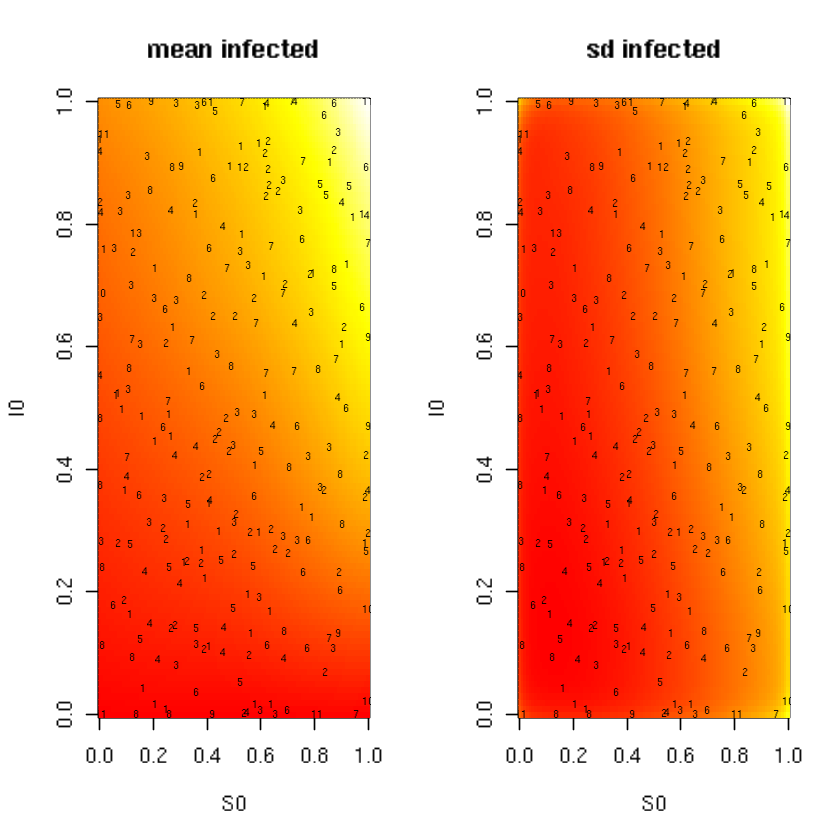

In [189]:
par(mfrow=c(1,2))
xx <- seq(0, 1, length=100)
image(xx, xx, matrix(p$mean, ncol=100), xlab="S0", ylab="I0", 
  col=cols, main="mean infected")
text(fit$X0, labels=fit$mult, cex=0.5)
image(xx, xx, matrix(sqrt(var), ncol=100), xlab="S0", ylab="I0", 
  col=cols, main="sd infected")
text(fit$X0, labels=fit$mult, cex=0.5)

In [190]:
mean(h > 1, na.rm=TRUE)

[1] 0.2477778

In [191]:
c(n=nrow(out.a$X0), N=length(out.a$Z), time=out.a$time)

n            N time.elapsed 
     1194.00      2000.00     38737.97

In [192]:
phet.a <- predict(out.a, Xtest)
phets2.a <- phet.a$sd2 + phet.a$nugs
mhet.a <- as.numeric(t(matrix(rep(phet.a$mean, 10), ncol=10)))
s2het.a <- as.numeric(t(matrix(rep(phets2.a, 10), ncol=10)))
sehet.a <- (unlist(t(Ztest)) - mhet.a)^2
sc.a <- - sehet.a/s2het.a - log(s2het.a)
c(batch=mean(sc), adaptive=mean(sc.a))

batch adaptive 
3.391718 3.615962

In [193]:
out.a <- rebuild(out.a)

In [194]:
Wijs <- Wij(out.a$X0, theta=out.a$theta, type=out.a$covtype)
h <- horizon(out.a, Wijs=Wijs)
control <- list(tol_dist=1e-4, tol_diff=1e-4, multi.start=30)
opt <- IMSPE_optim(out.a, h, Wijs=Wijs, control=control)

In [195]:
opt$par

0.6349862,0.03485281,0.6313505,0.4049574,0.9543986,0.5714038,0.4030497,0.9138594


In [196]:
opt$path[[1]]$new

[1] TRUE

In [197]:
source("/root/dataset/fksim.R")

In [198]:
x2 <- seq(0, 1, length=100)
y <- sapply(x2, function(x2) { fksim(c(0.8, x2)) })

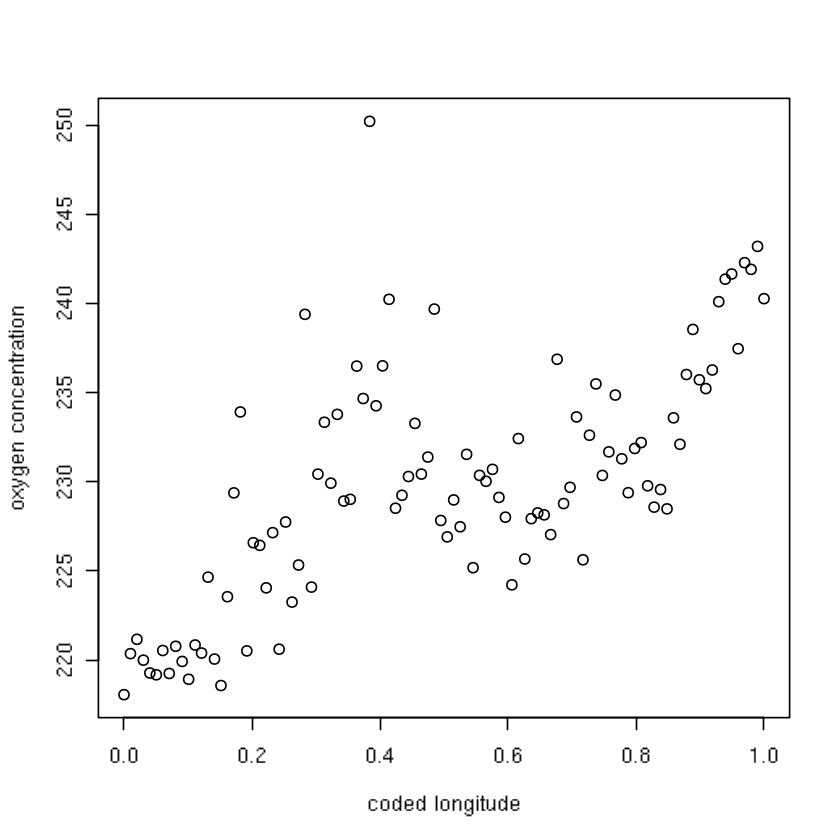

In [199]:
plot(x2, y, xlab="coded longitude", ylab="oxygen concentration")

In [200]:
library(mvtnorm)
lpost.invert <- function(theta, XF, yF, GP)
 {
  ## input processing and checking
  if(length(theta) != ncol(GP$X0) - ncol(XF) + 1) 
    stop("length(theta), ncol(XF), ncol(GP$X0) mismatch")
  u <- theta[-length(theta)]
  s2 <- theta[length(theta)]
  
  ## prior checking  
  if(any(u < 0 | u > 1)) return (-Inf)
  if(s2 < 0) return(-Inf)

  ## derive predictive distribution for XF paired with u
  XFU <- cbind(XF, matrix(rep(u, nrow(XF)), ncol=length(u), byrow=TRUE)) 
  p <- predict(GP, XFU, xprime=XFU)
  C <- s2*diag(nrow(p$cov)) + (p$cov + t(p$cov))/2

  ## gaussian log density evaluation for yF under that predictive
  return(dmvnorm(yF, p$mean, C, log=TRUE) - log(s2))
 }